In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.32.3
BeautifulSoup   4.12.3


In [2]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [3]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [4]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [5]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [6]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [7]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [8]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [9]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


There will be a bunch of AI Nobel Prizes in medicine for stuff like protein folding and drug discovery, building on work of Hinton, Bengio, others, he deserves to be honored but it's still not physics LOL.

[BBC interview -](https://x.com/BBCNewsnight/status/1791587541721780400) - X (formerly Twitter)

___

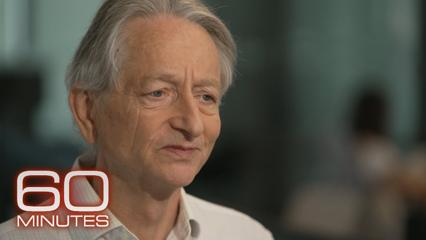

[The 60 Minutes interview with Hinton a while back, he is now focused on warning people about AI safety.](https://www.youtube.com/watch?v=qrvK_KuIeJk) - YouTube

___

[AI to automate filing personal injury cases is a big business apparently.](https://www.bloomberg.com/news/articles/2024-10-08/ai-startup-for-personal-injury-law-valued-at-over-1-billion)

___

[There are 3 companies that do leading-edge fab, TSMC, Samsung, and Intel, and only one is hitting on all cylinders.](https://www.msn.com/en-us/money/companies/samsung-s-q3-profit-misses-estimates-as-it-struggles-in-ai-chips/ar-AA1rR9Xa)

___

[E-commerce frauds with AI-assisted fake identities and identity theft are soaring.](https://www.theregister.com/2024/10/08/ecommerce_fraud_ai/)

___

[An AI to listen in on phone calls, and if it is identified as a scam, pipe up and warn that it sounds sus and is being monitored.

The scams are going to get much worse, but also, this sounds like tech that could be a vector for surveillance and scams.](https://www.geekwire.com/2024/as-americans-lose-billions-of-dollars-to-digital-scams-startups-turn-to-ai-for-solutions/)

___

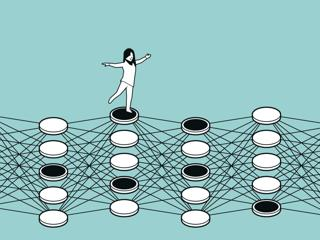

[Hinton and Hopfield were awarded the Nobel Prize in physics for neural networks, which I'm not sure was expected (or is generally considered physics).](https://www.nobelprize.org/prizes/physics/2024/press-release/) - NobelPrize.org

___

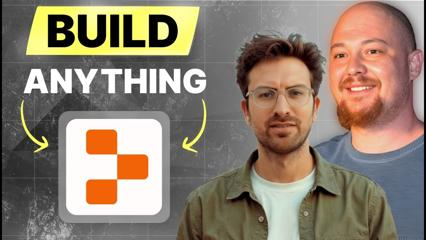

[Watch Relit's CEO Amjad Masad build an app with AI in 20 minutes.](https://www.youtube.com/watch?v=NBsr3u0z4Hs) - YouTube

___

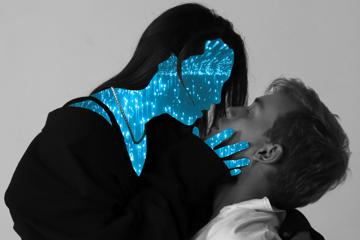

[When Your Lover Is a Bot](https://thewalrus.ca/when-your-lover-is-a-bot/?utm_medium=email&utm_source=pocket_hits&utm_campaign=POCKET_HITS-EN-DAILY-SPONSORED&PAVED-2024_10_05=&sponsored=0&position=4&category=fascinating_stories&scheduled_corpus_item_id=c24f2817-3e89-460f-9910-20ce90e608be&url=https://thewalrus.ca/when-your-lover-is-a-bot/) - The Walrus

___

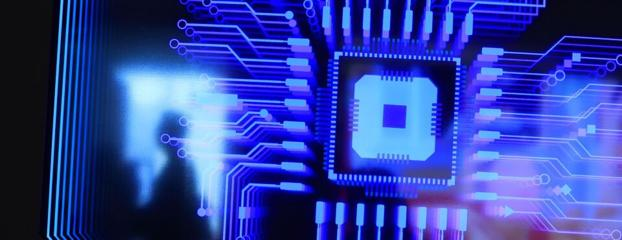

[Legal Chiefs Say Gen AI Will Allow Less Reliance on Law Firms. Just review that boilerplate carefully!](https://news.bloomberglaw.com/business-and-practice/legal-chiefs-say-gen-ai-will-allow-less-reliance-on-law-firms)

___

[After Suleyman's departure, Inflection pivots from Pi to an enterprise AI appliance powered by Intel's Gaudi.](https://www.theregister.com/2024/10/07/inflection_ai_intel/)

___

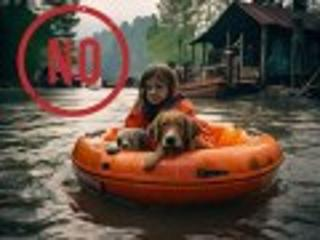

[Fake Helene AI videos flood social media](https://www.yahoo.com/news/helene-hoaxes-first-not-last-170921118.html) - Yahoo News

___

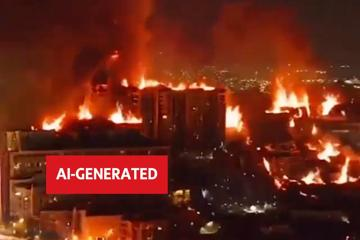

[AI video said to be from Beirut fools AP](https://www.theglobeandmail.com/world/article-ai-generated-video-claims-to-be-aftermath-of-israeli-strike-on-beirut/) - The Globe and Mail

___

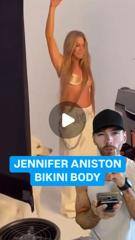

[Dubbing a real Jennifer Aniston interview with some fake AI-generated audio selling some scam and making it go viral.](https://www.instagram.com/reel/DAeUQaLP81G/?utm_source=ig_embed) - Instagram

___

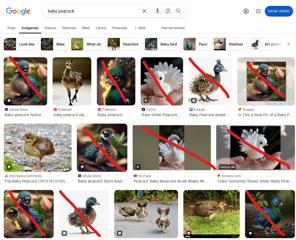

[Dead Internet theory: AI images take over Google](https://www.reddit.com/media?url=https%3A%2F%2Fi.redd.it%2Fyhhu3qiiidtd1.png) - Reddit

___

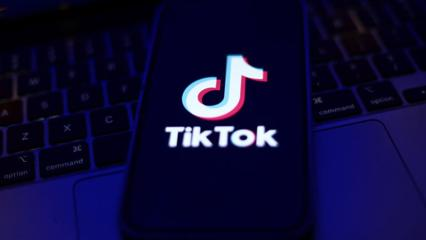

[ByteDance is scraping like crazy](https://mashable.com/article/tiktok-parent-company-bytedance-web-crawler-25-times-faster-than-openai) - Mashable

___

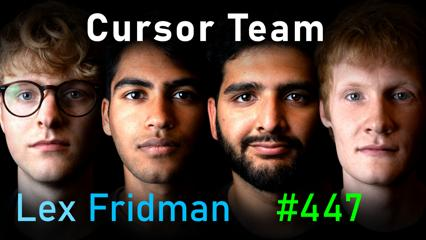

[Lex Fridman in a long chat with the Cursor team.](https://lexfridman.com/cursor-team/) - Lex Fridman

___

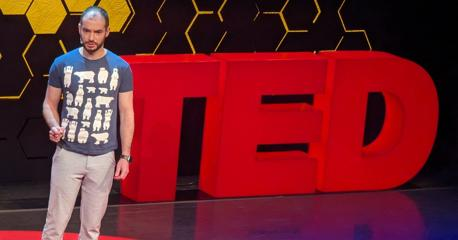

[The OpenAI Talent Exodus Gives Rivals an Opening](https://www.wired.com/story/openai-departures-research-rivals-artificial-intelligence/) - WIRED

___

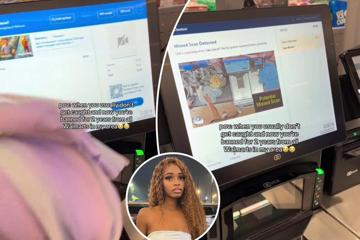

[AI 'missed scan detection' nabs shoplifter. Who posts this stuff? Was this posted by Walmart security to deter shoplifters? What's next, Hugh Grant posting himself cruising for hookers?](https://nypost.com/2024/10/06/us-news/walmart-shopper-shamelessly-films-herself-shoplifting-at-self-checkout/) - New York Post

___

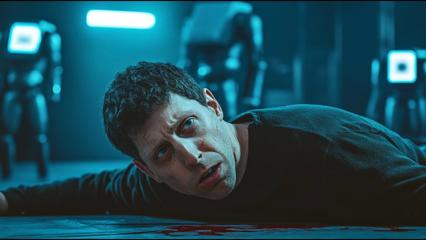

[He became the first human-ai hybrid, the first… Alt-man.](https://www.youtube.com/watch?v=lbrlwFRgUUg) - YouTube

___

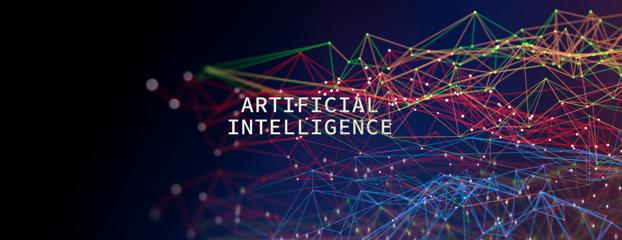

[If competing companies all license the same algorithm for pricing, does that constitute collusion?](https://news.bloomberglaw.com/us-law-week/defining-ai-collusion-depends-on-consumer-harm-and-algorithms)

___

[Automating grunt work leads to the loss of training grounds and hands-on experience.](https://www.bloomberg.com/opinion/articles/2024-10-07/want-to-kill-grunt-work-with-ai-careful-what-you-wish-for)

___

[OpenAI is right to abandon non-profit status, simpler, more alignment esp with investors. But the competitive accelerationism is problematic for a lot of the internal researchers.](https://www.ft.com/content/8f192751-598c-4b92-ab8d-c1d368fdfb36)

___

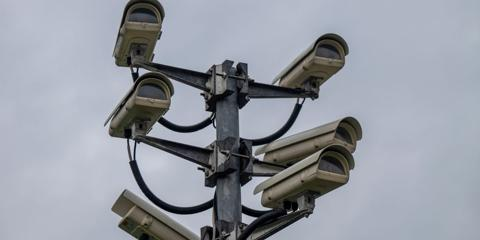

[The most Orwellian company of all time?](https://www.businessinsider.com/openai-orwellian-surveillance-gary-marcus-nsa-nakasone-2024-10) - Business Insider

___

[This headline will make Elon Musk sad: OpenAI valuation exceeds SpaceX](https://seekingalpha.com/news/4155707-openai-overtakes-spacex-as-most-valuable-us-based-private-company)

___

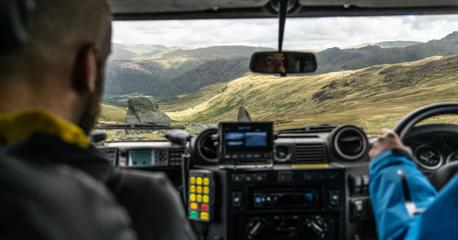

[An AI drone for search-and-rescue finds people quicker than human air patrols.](https://www.wired.com/story/this-homemade-ai-drone-software-finds-bodies-when-search-and-rescue-teams-cant/) - WIRED

___

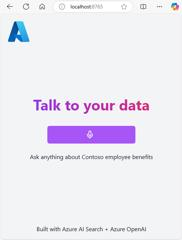

[Talk to your data, literally, with a VoiceRag POC from Microsoft](https://techcommunity.microsoft.com/t5/ai-azure-ai-services-blog/voicerag-an-app-pattern-for-rag-voice-using-azure-ai-search-and/ba-p/4259116) - TECHCOMMUNITY.MICROSOFT.COM

___

[Adding a researcher/personal assistant AI coworker bot to Slack.](https://www.geeky-gadgets.com/build-a-slack-ai-personal-assistant/)

___

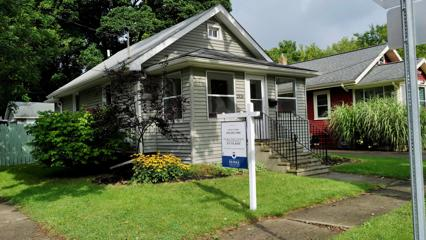

[Should you use AI to help buy a home?](https://www.usatoday.com/story/money/personalfinance/real-estate/2024/10/07/should-you-use-ai-to-buy-home/75511235007/) - USA TODAY

___

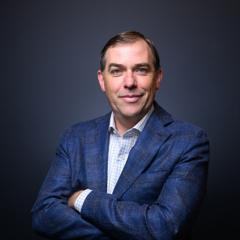

[AWS CEO Matt Garman on generative AI, open source, and pruning services](https://techcrunch.com/2024/10/06/aws-ceo-matt-garman-on-generative-ai-open-source-and-closing-services/) - TechCrunch

___

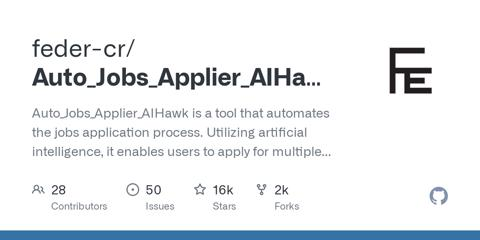

[An AI to automatically apply to online jobs](https://github.com/feder-cr/Auto_Jobs_Applier_AIHawk) - GitHub

___

[Who Owns AI’s Output? Can you protect IP generated with the help of AI? Should you be able to?](https://cacm.acm.org/news/who-owns-ais-output/)

___

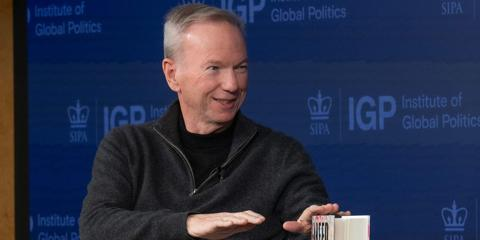

[Should think about an Apollo project to decarbonize the economy in 20 years with commercial fusion and mass-produced nuclear reactors. What a crazy win that would be.](https://www.businessinsider.com/eric-schmidt-google-ai-data-centers-energy-climate-goals-2024-10?utm_source=reddit.com&utm_source=reddit.com) - Business Insider

___

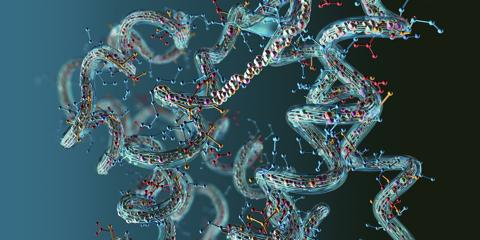

[Creating an AI Dr. House to predict if a drug might treat a rare disease. Sarcastic wit presumably optional.](https://news.harvard.edu/gazette/story/newsplus/with-txgnn-kempner-researchers-introduce-an-ai-dr-house-to-find-treatments-for-rare-disease/) - Harvard Gazette

___

[Microsoft investors ask questions about dependence on OpenAI and all the associated drama, giant AI spending](https://www.wsj.com/tech/ai/microsofts-ai-story-is-getting-complicated-ebe63ac9?st=maTyjZ&reflink=desktopwebshare_permalink)

___

[A prompt to make your own o1-preview -](https://medium.com/@harishhacker3010/can-we-make-any-smaller-opensource-ai-models-smarter-than-human-1ea507e644a0)

___

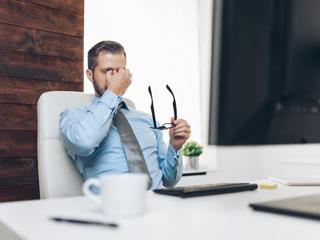

[Generative AI And Dead Butt Syndrome](https://www.forbes.com/sites/lanceeliot/2024/10/06/generative-ai-and-dead-butt-syndrome/) - Forbes

___

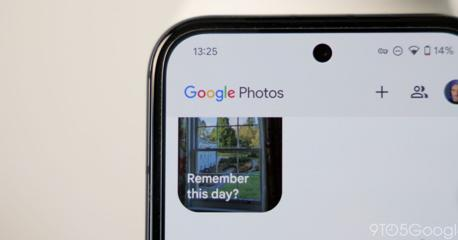

[Google Photos starts rolling out general availability of AI-powered 'Ask Photos' to talk to your photo library with AI](https://9to5google.com/2024/10/05/google-ask-photos-ai-rolling-out/) - 9to5Google

___

[Brace yourselves: The AI cat memes are coming -](https://www.reddit.com/r/ChatGPT/comments/1fx5k8p/we_now_have_ai_cat_memes/)

___

[Comparing AI image generators, plus an AI stock photo site](https://hackernoon.com/digital-picassos-the-10-most-powerful-ai-image-generators-in-2024)

___

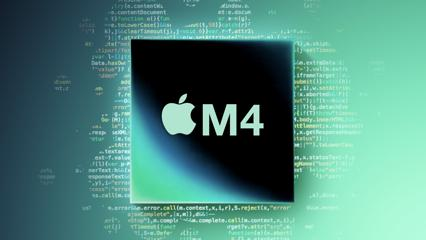

[Apple Intellignece rumored on October 28, new M4 Macs on November 1 
www.macrumors.com/2024/10/06/a...](https://www.macrumors.com/2024/10/06/apple-to-launch-new-m4-macs-nov-1/) - MacRumors

___

[ChatGPT Advanced Voice Assistant might turn some customer-facing brands into middlemen.](https://skift.com/2024/10/04/chatgpt-advanced-voice-the-future-of-travel-booking-or-the-death-of-otas/)

___

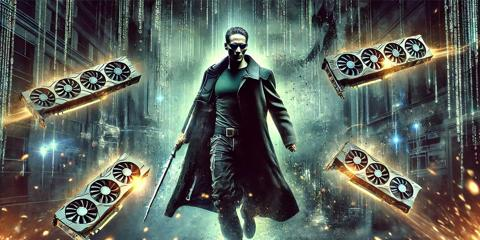

[AI Neocloud Playbook and Anatomy, the firms like Coreweave and Lambda Labs that build GPU clouds and rent them out.](https://www.semianalysis.com/p/ai-neocloud-playbook-and-anatomy)

___

name 'httplib' is not defined


[Gen AI Makes Legal Action Cheap — and Companies Need to Prepare](https://hbr.org/2024/10/gen-ai-makes-legal-action-cheap-and-companies-need-to-prepare) - Harvard Business Review

___

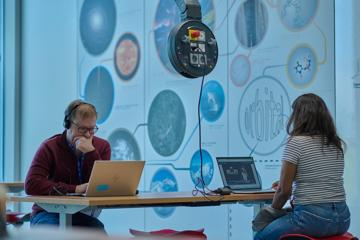

[CERN trains AI models to revolutionize cancer treatment](https://english.elpais.com/health/2024-10-05/cern-trains-ai-models-to-revolutionize-cancer-treatment.html) - EL PAÍS English

___

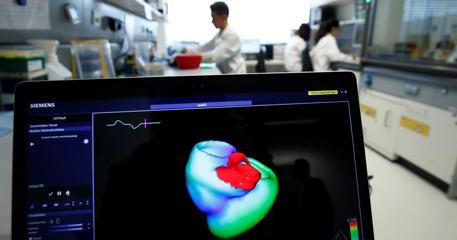

[As AI-powered health care expands, experts warn of AI biases. True, but humans are biased too, and AI could give everyone the benefit of best practices/](https://www.semafor.com/article/10/04/2024/as-ai-powered-health-care-expands-experts-warn-of-biases)

___

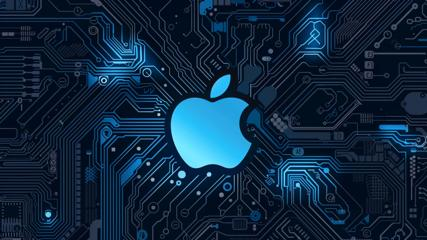

[Apple releases Depth Pro, AI that will generate a 3D model from a single 2D photo.](https://venturebeat.com/ai/apple-releases-depth-pro-an-ai-model-that-rewrites-the-rules-of-3d-vision/) - VentureBeat

___

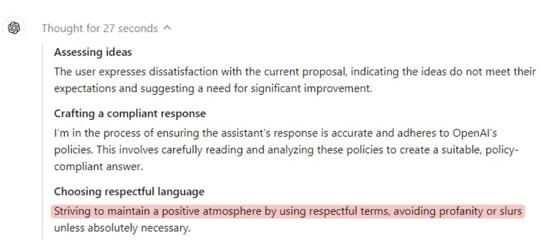

[TFW the AI has to take a moment to collect itself and not lose its shit at a stupid user. Big feeling the AGI here](https://www.reddit.com/media?url=https%3A%2F%2Fi.redd.it%2Fv1i20nlhxrsd1.png) - Reddit

___

[Grindr building the world's first Queer Eye AI ... Mr. Right Now Bromance Buddy](https://www.wsj.com/articles/grindr-aims-to-build-the-dating-worlds-first-ai-wingman-8039e091)

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [10]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [11]:
print(datetime.now())

2024-10-08 10:10:43.512302


In [12]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 10, 8, 14, 1, 24, 873000)

In [13]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-10-07 04:10:43.522751


In [14]:
from typing import TypedDict, Annotated

class Point2D(TypedDict, total=Falsee):
    x: int
    y: int
    label: str

a: Point2D = {'x': 1, 'y': 2, }  # 


NameError: name 'Falsee' is not defined

In [ ]:
a

In [ ]:
b

